In [ ]:
# -*- coding: utf-8 -*-
!pip install pyvi
from __future__ import print_function
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import SGDClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pyvi import ViTokenizer
import re
import string
import codecs
import json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 64.2 MB/s eta 0:00:00


In [ ]:
### tiền sử lý văn bản, chuẩn hóa dữ liệu

In [ ]:
#Từ điển tích cực, tiêu cực, phủ định
path_nag = '/content/drive/MyDrive/sentiment_analysis/data_clean/VietNamese_sentiment_dictionary/nag.txt'
path_pos = '/content/drive/MyDrive/sentiment_analysis/data_clean/VietNamese_sentiment_dictionary/pos.txt'
path_not = '/content/drive/MyDrive/sentiment_analysis/data_clean/VietNamese_sentiment_dictionary/not.txt'

with codecs.open(path_nag, 'r', encoding='UTF-8') as f:
    nag = f.readlines()
nag_list = [n.replace('\n', '') for n in nag]

with codecs.open(path_pos, 'r', encoding='UTF-8') as f:
    pos = f.readlines()
pos_list = [n.replace('\n', '') for n in pos]
with codecs.open(path_not, 'r', encoding='UTF-8') as f:
    not_ = f.readlines()
not_list = [n.replace('\n', '') for n in not_]

# xác định các kí tự có dấu trong tiếng Việt
VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'
VN_CHARS_UPPER = u'ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸÐĐ'
VN_CHARS = VN_CHARS_LOWER + VN_CHARS_UPPER

In [ ]:
#Viết hàm loại bỏ dấu ủa kí tự
def no_marks(s):
    __INTAB = [ch for ch in VN_CHARS]
    __OUTTAB = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"*2
    __OUTTAB += "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"*2
    __r = re.compile("|".join(__INTAB))
    __replaces_dict = dict(zip(__INTAB, __OUTTAB))
    result = __r.sub(lambda m: __replaces_dict[m.group(0)], s)
    return result


In [ ]:
#Viết hàm để chuẩn hóa các từ teencode, emoji, sai chính tả, tiếng anh, dấu câu,...
def normalize_text(text):

    #Remove các ký tự kéo dài: vd: đẹppppppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    # Chuyển thành chữ thường
    text = text.lower()

    #Chuẩn hóa tiếng Việt, xử lý emoj, chuẩn hóa tiếng Anh, thuật ngữ
    with open('/content/drive/MyDrive/sentiment_analysis/list.json', 'r',encoding='utf-8') as file:
        data = json.load(file)

    replace_list = data

    for k, v in replace_list.items():
        text = text.replace(k, v)

    # chuyển dấu câu thành space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)

    text = ViTokenizer.tokenize(text)  # Thực hiện tokennize các câu
    texts = text.split()
    len_text = len(texts)

    texts = [t.replace('_', ' ') for t in texts]# bỏ dấu "_" trong các token

 # Xử lý vấn đề phủ định (VD: áo này chẳng đẹp--> áo này notpos)
    for i in range(len_text):
        cp_text = texts[i]
        if cp_text in not_list: # nếu có từ phủ định thì thực hiện đổi thành 'notpos' hoặc 'notnag'
            numb_word = 2 if len_text - i - 1 >= 4 else len_text - i - 1

            for j in range(numb_word):
                if texts[i + j + 1] in pos_list:
                    texts[i] = 'notpos'
                    texts[i + j + 1] = ''

                if texts[i + j + 1] in nag_list:
                    texts[i] = 'notnag'
                    texts[i + j + 1] = ''
        else: #Thêm feature cho những sentiment words vào cuối câu nếu nó không có từ phủ định (áo này đẹp--> áo này đẹp positive)
            if cp_text in pos_list:
                texts.append('positive')
            elif cp_text in nag_list:
                texts.append('nagative')

    text = u' '.join(texts)

    #remove nốt những ký tự thừa thãi như "", kí tự đặc biệt
    text = text.replace(u'"', u' ')
    text = text.replace(u'️', u'')
    text = text.replace('🏻','')
    return text

In [ ]:
#Text hàm chẩn hóa
print(normalize_text('không đẹp xíu nào'))
print(normalize_text('không xấu nha'))
print(normalize_text(' đẹp quá'))
print(normalize_text('sản phẩm không thể chê vào đâu được, quá tuyệt vời '))

notpos  xíu nào
notnag  nha
đẹp quá positive
sản phẩm không thể chê vào đâu được quá tuyệt vờ yêu positive positive positive


In [ ]:
# tạo class với các phương thức để truy cập dữ liệu
class DataSource(object):
    #Hàm đọc dữ liệu từ file và chia  thành các comment riêng biệt của từng khách hàng .
    def _load_raw_data(self, filename, is_train=True):

        a = []
        b = []

        regex = 'train_'
        if not is_train:
            regex = 'test_'

        with open(filename, 'r') as file:
            for line in file:
                if regex in line:
                    b.append(a)
                    a = [line]
                elif line != '\n':
                    a.append(line)
        b.append(a)

        return b[1:]
    # Đối cới một khách hàng tạo ra một dictionary bao goomg ID, lable, và phần comment
    def _create_row(self, sample, is_train=True):

        d = {}
        d['id'] = sample[0].replace('\n', '')
        review = ""

        if is_train:
            for clause in sample[1:-1]:
                review += clause.replace('\n', ' ')
                review = review.replace('.', ' ')

            d['label'] = int(sample[-1].replace('\n', ' '))
        else:
            for clause in sample[1:]:
                review += clause.replace('\n', ' ')
                review = review.replace('.', ' ')


        d['review'] = review

        return d
    # Viết hàm thực hiện kết hợp hai phương thức _load_raw_data và _create_row để chiuyeenr tất cả dữ liệu thabhf một danh sách hoàn chỉnh
    def load_data(self, filename, is_train=True):

        raw_data = self._load_raw_data(filename, is_train)
        lst = []

        for row in raw_data:
            lst.append(self._create_row(row, is_train))

        return lst
    # Hàm thực hiện việc chuẩn hóa dữ liệu
    def transform_to_dataset(self, x_set,y_set):
        X, y = [], []
        for document, topic in zip(list(x_set), list(y_set)):
            document = normalize_text(document)
            X.append(document.strip())
            y.append(topic)
            #Augmentation bằng cách remove dấu tiếng Việt
            X.append(no_marks(document))
            y.append(topic)
        return X, y


In [ ]:
##  load và xử lý dữ liệu từ train.crash cho tập train, sau đó nối thêm dữ liệu mới vào dữ liệu huấn luyện

ds = DataSource()
train_data = pd.DataFrame(ds.load_data('/content/drive/MyDrive/sentiment_analysis/data_clean/train.crash'))
new_data = []

#Thêm mẫu bằng cách lấy trong từ điển Sentiment (nag/pos)
for index,row in enumerate(nag_list):
    new_data.append(['pos'+str(index),'0',row])
for index,row in enumerate(nag_list):
    new_data.append(['nag'+str(index),'1',row])

new_data = pd.DataFrame(new_data,columns=list(['id','label','review']))
train_data.append(new_data)

# load dữ liệu cho tập test từ test.crash
test_data = pd.DataFrame(ds.load_data('/content/drive/MyDrive/sentiment_analysis/data_clean/test.crash', is_train=False))

<ipython-input-9-9917524a8c0f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data.append(new_data)


In [ ]:
### Try model MultinomialNB
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import LinearSVC
# classifiers = MultinomialNB(),

In [ ]:

###Try model DecisionTreeClassifier
# from sklearn.tree import DecisionTreeClassifier
# classifiers = MultinomialNB(),

In [ ]:

# model LinearSVC
classifiers = LinearSVC(fit_intercept = True,multi_class='crammer_singer', C=1),


##chuyển đổi dữ liệu kiểm tra thành dạng phù hợp để kiểm tra mô hình.
X_train, X_test, y_train, y_test = train_test_split(train_data.review, train_data.label, test_size=0.3,random_state=42)
X_train, y_train = ds.transform_to_dataset(X_train,y_train)
X_test, y_test = ds.transform_to_dataset(X_test, y_test)



In [ ]:
#THÊM STOPWORD LÀ NHỮNG TỪ KÉM QUAN TRỌNG
stop_ws = [u'rằng',u'thì',u'là',u'mà']

In [ ]:
# Thực hiện mô hình phân loại và gán nhãn cho dữ liệu 0: posity, 1 negative
for classifier in classifiers:
    steps = []
    steps.append(('CountVectorizer', CountVectorizer(ngram_range=(1,5),stop_words=stop_ws,max_df=0.5, min_df=5)))
    steps.append(('tfidf', TfidfTransformer(use_idf=False, sublinear_tf = True,norm='l2',smooth_idf=True)))
    steps.append(('classifier', classifier))
    clf = Pipeline(steps)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report1 = metrics.classification_report(y_test, y_pred, labels=[1,0], digits=3)

X_train, y_train = ds.transform_to_dataset(train_data.review, train_data.label)




In [ ]:
#TRAIN OVERFITTING/ERRO ANALYSIS
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
report2 = metrics.classification_report(y_train, y_pred, labels=[1,0], digits=3)


In [ ]:

#ERRO ANALYSIS
# Cho thấy các trường hợp mà nhãn dự đoán của mô hình (y_pred) không trùng khớp với nhãn thực tế (y_train).
for id,x, y1, y2 in zip(train_data.id, X_train, y_train, y_pred):
    if y1 != y2:
        # CHECK EACH WRONG SAMPLE POSSITIVE/NAGATIVE
        if y1!=1:#0:
            print(id,x, y1, y2)# In ra các trường hợp phân loại sai


train_000062 hàng vận chuyển bị nứt mẻ 1 góc chất lượng o không nagative nagative positive 0 1
train_000063 hang van chuyen bi nut me 1 goc chat luong o khong nagative nagative positive 0 1
train_000138 thờ yêu g yêu an g yêu ao hàng rất nhanh cửa hàng phuc vụ quá qua tệ hang bị hư hạ yêu ma hong lờ yêu g yêu a yêu quyết ngườ yêu khác da the ma nguo yêu k yêu a cũng vay hong chu đáo can xem xet lạ yêu kh yêu mau hàng cửa hàng nay nha cac ban positive positive positive nagative nagative nagative positive positive positive positive positive positive positive positive positive positive 0 1
train_000139 tho yeu g yeu an g yeu ao hang rat nhanh cua hang phuc vu qua qua te hang bi hu ha yeu ma hong lo yeu g yeu a yeu quyet nguo yeu khac da the ma nguo yeu k yeu a cung vay hong chu dao can xem xet la yeu kh yeu mau hang cua hang nay nha cac ban positive positive positive nagative nagative nagative positive positive positive positive positive positive positive positive positive positive 0 1
tr

In [ ]:
#Đánh giá mô hình
#CROSS VALIDATION
cross_score = cross_val_score(clf, X_train,y_train, cv=5)

In [ ]:
# in kết quả đánh giá
print('DATASET LEN %d'%(len(X_train)))
print('TRAIN 70/30 \n\n',report1)
print('TRAIN OVERFITING\n\n',report2)
print("CROSSVALIDATION 5 FOLDS: %0.4f (+/- %0.4f)" % (cross_score.mean(), cross_score.std() * 2))

DATASET LEN 32146
TRAIN 70/30 

               precision    recall  f1-score   support

           1      0.918     0.939     0.928      4438
           0      0.947     0.929     0.938      5206

    accuracy                          0.933      9644
   macro avg      0.932     0.934     0.933      9644
weighted avg      0.934     0.933     0.933      9644

TRAIN OVERFITING

               precision    recall  f1-score   support

           1      0.973     0.979     0.976     14766
           0      0.982     0.977     0.980     17380

    accuracy                          0.978     32146
   macro avg      0.978     0.978     0.978     32146
weighted avg      0.978     0.978     0.978     32146

CROSSVALIDATION 5 FOLDS: 0.9318 (+/- 0.0101)


In [ ]:
##lưu dữ liệu kết quả phân tích vào FILE SUBMIT
test_list = []
for document in test_data.review:
    document = normalize_text(document)
    test_list.append(document)
y_predict = clf.predict(test_list)
test_data['label'] = y_predict
# test_data['content'] = test_list
test_data = test_data.sort_values(by=['label'])
test_data[['id', 'label']].to_csv('submit.csv', index=False)

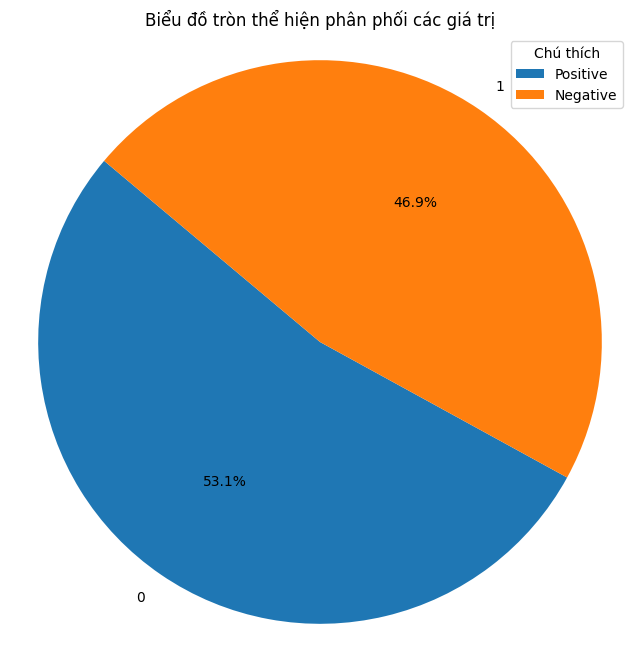

In [ ]:
##phân tích kết quả thu được bằng đồ thị:
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV vào một DataFrame của pandas
data = pd.read_csv('submit.csv')
# Xác định cột dữ liệu bạn muốn sử dụng để vẽ biểu đồ tròn
column_to_plot = 'label'

# Tính toán số lần xuất hiện của từng giá trị trong cột dữ liệu
value_counts = data[column_to_plot].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 8))
domain_names = ['Positive','Negative']
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Đảm bảo biểu đồ tròn có hình dạng hợp lý
plt.title('Biểu đồ tròn thể hiện phân phối các giá trị')
plt.legend(domain_names, title='Chú thích', loc='upper right')
plt.show()

# Mục mới